### Execution environment
Since Jupyter notebookes work from a different directory the code block below changes the execution path to the root of the project

In [1]:
from EE_ContextGenerator import key_context as context
import os

dir = os.getcwd()
if dir.split("/")[-3] == "codebase":
    os.chdir("../../")


Is the context private? Yes
Automatic relinearization is: on
Automatic rescaling is: on
Automatic modulus switching is: on


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


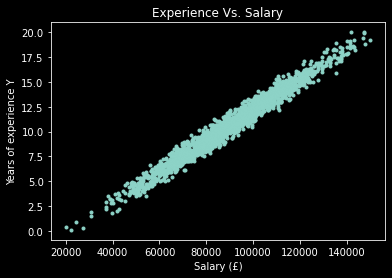

In [2]:
%load_ext memory_profiler   
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tenseal as ts
import time
import dataset_generator as dg  # Import dataset_generator.py

## Logging Handler
Everything in the cell below is to prepare the logging mechanism to analyse the output

In [3]:
# importing module
from csv_logger import CsvLogger
import logging

filename = f"./EE_Log/Sample {dg.n_samples}, Noise {dg.noise}.csv"
delimiter = ","
level = logging.INFO
fmt = f"%(asctime)s{delimiter}%(levelname)s{delimiter}%(message)s"
datefmt = "%Y/%m/%d %H:%M:%S"
level = logging.INFO
header = [
    "Date",
    "Level",
    "Loss",
    "Degree of accuracy (Decimal place)",
    "Plain test accuracy",
    "Encrypted test accuracy",
    "Testing time",
    "Encrypted testing time",
    "Memory of model",
    "Cleartext testing memory usage",
    "Encrypted testing memory usage ",
    "Encrypting testset memory usage ",
]
csvlogger = CsvLogger(
    filename=filename,
    delimiter=delimiter,
    level=level,
    fmt=fmt,
    datefmt=datefmt,
    header=header,
)


To create consistency of random events to make the project reproducible

In [4]:
torch.random.manual_seed(10)


In [5]:
def memit_parser(std):
    # This function parses the output of the memory_profiler module
    std = str(std)
    return std.split(" ")[2]


LinearRegression Model

In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out


Train test split, It is imperative to understand why the x_test data is the **salary**. 

This is because the **salary** is sensitive data in this scenario there, it is going to be the inputs for our model thus making it the X value. We'll be mapping this **salary** to the expected years of experience.  

In [7]:
def test_train_split(df):
    training_data = df.sample(frac=0.8, random_state=25)  #
    testing_data = df.drop(training_data.index)
    y_train, x_train = (
        training_data["YearsExperience"].to_numpy(),
        training_data["Salary"].to_numpy(),
    )
    y_test, x_test = (
        testing_data["YearsExperience"].to_numpy(),
        testing_data["Salary"].to_numpy(),
    )
    return x_train, y_train, x_test, y_test


## Visualisation of the dataset.

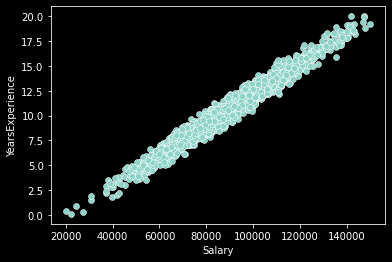

In [8]:
df = pd.read_csv("./LinearRegression/Data/Custom_Salary_Data.csv")
sns.scatterplot(data=df, x="Salary", y="YearsExperience")
plt.show()


In [9]:
x_train, y_train, x_test, y_test = test_train_split(df)
# Vectorising dataset
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


## Parameters
Outlined below is the parameters used for the PyTorch model.
It will be using: 
Mean Absolute Error, for the loss function
A learning rate of: 0.00005| Which will be used for the stochastic gradient descent
The optimiser is stochastic gradient descent
Epochs: 2000, Number of iterations for the gradient descent, was decided after multiple training periods

In [10]:
model = LinearRegressionModel(1, 1)  # single dimension
criterion = nn.L1Loss(reduction="mean")  # mean absolute error
learning_rate = 5e-5

optimiser = torch.optim.SGD(
    model.parameters(), lr=learning_rate
)  # stochastic gradient descent
EPOCHS = 2000  # Number of iterations
model = model.double()  # Scaling the model to cater to larger values


In [11]:
# Convert numpy array to torch Variable
x_train_tensor = torch.from_numpy(x_train).double().requires_grad_()
y_train_tensor = torch.from_numpy(y_train).double().requires_grad_()

x_test_tensor = torch.from_numpy(x_test).double()
y_test_tensor = torch.from_numpy(y_test).double()


In [12]:
def train(model, optimiser, criterion, inputs, labels, epochs=EPOCHS):
    for epoch in range(epochs + 1):

        # Forward to get output
        outputs = model(inputs)

        # Calculate Loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        ##Clip gradient
        nn.utils.clip_grad_norm_(model.parameters(), 1)

        # Updating parameters
        optimiser.step()

        # Clear gradients w.r.t. parameters
        optimiser.zero_grad()

        if epoch % 200 == 0:
            print("epoch {}, loss {}".format(epoch, loss.item()))
        elif np.isnan(loss.item()):
            print("epoch {}, loss {}".format(epoch, loss.item()))
            break
        if loss.item() < 0.01:
            print("epoch {}, loss {}".format(epoch, loss.item()))
            break
    global Final_LOSS
    Final_LOSS = loss.item()
    return model


In [13]:
mu_model = %memit -o model = train(model, optimiser, criterion, x_train_tensor, y_train_tensor, EPOCHS)
mu_model = memit_parser(mu_model)

epoch 0, loss 7579.881568164525
epoch 200, loss 6676.967952869029
epoch 400, loss 5774.054337573536
epoch 600, loss 4871.140722278149
epoch 800, loss 3968.2271069827793
epoch 1000, loss 3065.31349168741
epoch 1200, loss 2162.3998763920404
epoch 1400, loss 1259.4862610966707
epoch 1600, loss 356.5726458013014
epoch 1800, loss 4.592800215876793
epoch 2000, loss 4.592800050348271
peak memory: 430.16 MiB, increment: 7.16 MiB


## Accuracy model
Outlined below is our accuracy model, it inputs our test set into the model, which is unseen to it.
Rounds it's estimate of the years of experience (Rounds depending on the decimal accuracy variable) this individual has dependent on their salary, then comapares it with their actual experience.

-1 = To the nearest whole number
1 = To one decimal place

In [14]:
def accuracy(model, x, y):
    t_start = time.time()
    with torch.no_grad():  # no need to calculate gradients for testing
        y_pred_experience = model(x)
        y_pred_experience = torch.round(
            y_pred_experience, decimals=decimal_accuracy
        )  # nearest year experience rounded to whole number
        y_real_rounded = torch.round(
            y, decimals=decimal_accuracy
        )  # real salary (rounded unit: the thousands) LHS of the decimal
        accuracy = torch.eq(y_pred_experience, y_real_rounded)
    t_end = time.time()
    global duration
    duration = t_end - t_start
    return torch.sum(accuracy).item() / len(accuracy) * 100


In [15]:
decimal_accuracy = -1 # -1 = nearest whole number, 0 = 1 decimal place
mu_plain_acuracy = %memit -o plain_accuracy = accuracy(model, x_test_tensor, y_test_tensor)
mu_plain_acuracy = memit_parser(mu_plain_acuracy)
print(f"Accuracy on plain test_set: {plain_accuracy}, duration: {duration}")

peak memory: 430.40 MiB, increment: 0.05 MiB
Accuracy on plain test_set: 93.25, duration: 0.0002980232238769531


# Encrypted Wrapper
A wrapper class to provide Tenseal Capabilities to the Linear regression model

In [16]:
class EncryptedLR:
    def __init__(self, torch_linear_model):
        # TenSEAL processes lists and not torch tensors,
        # so we take out the parameters from the PyTorch model
        self.weight = torch_linear_model.linear.weight.data.tolist()[0]
        self.bias = torch_linear_model.linear.bias.data.tolist()

    def forward(self, enc_x):
        # Propogate the network
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    ################################################
    ## You can use the functions below to perform ##
    ## the evaluation with an encrypted model     ##
    ################################################

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()


In [17]:
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time.time()
    with torch.no_grad():
        y_pred_enc = model(enc_x_test)
        y_pred_output = y_pred_enc.decrypt()
        # Converting PlainTensor into pytorch tensor https://github.com/OpenMined/TenSEAL/blob/main/tutorials/Tutorial%202%20-%20Working%20with%20Approximate%20Numbers.ipynb
        y_pred_output = y_pred_output.tolist()
        y_pred_output = torch.FloatTensor(y_pred_output)
        ##################################################
        y_pred_output = torch.round(y_pred_output, decimals=decimal_accuracy)
        y_real_rounded = torch.round(
            y_test, decimals=decimal_accuracy
        )  # Rounding the Years of experience to the nearest whole number
        y_real_rounded = torch.flatten(y_real_rounded)
        accuracy = torch.eq(y_pred_output, y_real_rounded)
    t_end = time.time()
    global encrypted_duration
    encrypted_duration = t_end - t_start
    correct_guess = torch.sum(accuracy).item()
    return correct_guess / len(accuracy) * 100


In [18]:
encrypted_linear_regression_model = EncryptedLR(model)

mu_encrypted_x_test_tensor = %memit -o encrypted_x_test_tensor = ts.ckks_tensor(context, x_test_tensor.detach().numpy())
mu_encrypted_x_test_tensor = memit_parser(mu_encrypted_x_test_tensor)

peak memory: 744.55 MiB, increment: 313.95 MiB


In [19]:
mu_E_accuracy = %memit -o E_accuracy = encrypted_evaluation(encrypted_linear_regression_model, encrypted_x_test_tensor, y_test_tensor)
mu_E_accuracy = memit_parser(mu_E_accuracy)
print(f"Accuracy on encrypted test_set: {E_accuracy}, duration: {encrypted_duration}")


peak memory: 1197.41 MiB, increment: 452.83 MiB
Accuracy on encrypted test_set: 93.25, duration: 0.7250711917877197


In [20]:
diff_accuracy = plain_accuracy - E_accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print(
        "Oh! We got a better accuracy on the encrypted test-set! The noise was on our side..."
    )


Difference between plain and encrypted accuracies: 0.0


In [21]:
# Log findings
csvlogger.info(
    f"{Final_LOSS}, {decimal_accuracy}, {plain_accuracy}, {E_accuracy}, {duration}, {encrypted_duration} , {mu_model}, {mu_plain_acuracy}, {mu_E_accuracy} ,{mu_encrypted_x_test_tensor}"
)
